In [1]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from scipy.stats import bernoulli 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=256, mask_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.mask_size = mask_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".jpg" #".bmp" 
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 0)
        image = cv2.resize(image, (self.image_size, self.image_size))
        #image_LTP = np.ones([128,128,3])
        #for i in range(image.shape[2]):
         #   image_LTP[:,:,i] = LTP(image[:,:,i])
        #image = image_LTP
        
        mask = np.zeros((self.mask_size, self.mask_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.mask_size, self.mask_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [3]:
image_size = 128
train_path = "dataset/ISICDATA/" #"dataset/PH2_Dataset_images/" #
epochs = 100
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 13

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]
valid_ids

['ISIC_0000001',
 'ISIC_0000003',
 'ISIC_0000004',
 'ISIC_0000006',
 'ISIC_0000007',
 'ISIC_0000008',
 'ISIC_0000009',
 'ISIC_0000011',
 'ISIC_0000012',
 'ISIC_0000013',
 'ISIC_0000014',
 'ISIC_0000015',
 'ISIC_0000016']

In [4]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=256, mask_size=128)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)
len(gen)

(8, 256, 256) (8, 128, 128, 1)


323

In [5]:
gentest = DataGen(valid_ids, train_path, batch_size=batch_size, image_size=256, mask_size=128)


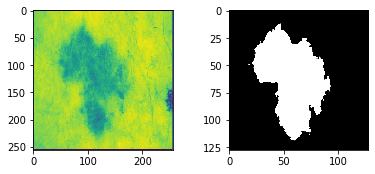

In [6]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [7]:
len(gen)

323

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvLBC(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size=3, sparsity=0.5, padding=0):
        '''
        Description:
            -- Initialize anchor weights.
            -- Generate out_channels anchor weights with sparsity
        Parameters:
            -- sparsity: the sparsity of anchor weights
        '''
        super().__init__(in_channels, out_channels, kernel_size, padding=padding, bias=False)
        anchor_weights = next(self.parameters())
        matrix_proba = torch.FloatTensor(anchor_weights.data.shape).fill_(0.5)
        binary_weights = torch.bernoulli(matrix_proba) * 2 - 1
        mask_inactive = torch.rand(matrix_proba.shape) > sparsity
        binary_weights.masked_fill_(mask_inactive, 0)
        anchor_weights.data = binary_weights
        anchor_weights.requires_grad = False


class LayerLBC(nn.Module):
    def __init__(self, in_channels, out_channels, num_weights=8, sparsity=0.5, kernel_size=3, padding=0):
        '''
        Description:
            -- Initialize a LBP Layer.
        Parameters:
            -- num_weights: the number of anchor_weights of each output channel
            -- sparsity: the sparsity of anchor weight
        '''
        super().__init__()
        # Generate out_channels*anchor_weights anchor weights 
        self.conv_lbp = ConvLBC(in_channels, out_channels*num_weights, kernel_size=kernel_size, sparsity=sparsity, padding=padding)
        # 1x1 convolution layer
        self.conv_1x1 = nn.Conv2d(num_weights, 1, kernel_size=1)
        self.num_weights = num_weights
        self.output_channel = out_channels

    def forward(self, x):
        x = F.relu(self.conv_lbp(x))
        x = x.view(x.size(0)*self.output_channel, self.num_weights, x.size(2), x.size(3))
        x = self.conv_1x1(x)
        x = x.view(x.size(0)//self.output_channel, self.output_channel, x.size(2), x.size(3))
        return x
    
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
    
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        #self.conv2 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.convv = double_conv(in_ch, out_ch)
        self.up_conv = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        #self.conv = double_conv(in_ch, out_ch)
        self.conv = DoubleConv(in_ch, out_ch)
    
    def forward(self, x1, x2):
        #x1 = self.convv(x1)
        x1 = self.up_conv(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class last_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(last_conv, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        return x

class SimpleNetLBC(nn.Module):
    '''
    Description:
        -- A simple model based on LBCNN
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            LayerLBC(in_channels=1, out_channels=16, num_weights=8, sparsity= 0.9, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            LayerLBC(in_channels=16, out_channels=32, num_weights=8, sparsity= 0.9, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.conv3 = nn.Sequential(
            LayerLBC(in_channels=32, out_channels=64, num_weights=8, sparsity= 0.9, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv4 = nn.Sequential(
            LayerLBC(in_channels=64, out_channels=128, num_weights=8, sparsity= 0.9, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv5 = nn.Sequential(
            LayerLBC(in_channels=128, out_channels=256, num_weights=8, sparsity= 0.9, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.up1 = up(256, 128) # 8 ----> 16
        self.up2 = up(128, 64)  # 16 ---> 32
        self.up3 = up(64, 32)   # 32 ---> 64
        self.up4 = up(32, 16)   # 64 ---> 128
        #self.otc = double_conv(16,1)
        #self.up5 = up(16, 1)    # 128 ---> 
        #self.outc = OutConv(8, 1)
        self.out = last_conv(16,1)

    def forward(self, x):
        #x0 = self.conv5(x)
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        #x = self.up5(x, x1)
        #x = self.up1(x2, x1)
        logits = self.out(x) #self.outc(x)
        return logits
    #def forward(self, x):
     #   out = self.conv1(x)
      #  out = self.conv2(out)
       # out = out.view(x.shape[0], -1)
        #out = self.fc_layers(out)
        #return out


In [9]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    
    y_true = y_true.view([y_true.shape[0], 128, 128,1])
    y_pred = y_pred.view([y_pred.shape[0], 128, 128, 1])
    y_true = y_true.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    
    with tf.Session() as sess:
        iou = sess.run(iou)
        
    return iou

Using TensorFlow backend.


In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    
    y_true = y_true.view([y_true.shape[0], 128, 128,1])
    y_pred = y_pred.view([y_pred.shape[0], 128, 128, 1])
    y_true = y_true.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    
    with tf.Session() as sess:
        dice = sess.run(dice)
    
    return dice

In [11]:
#train_loader = torch.utils.data.DataLoader(gen, batch_size=8, shuffle=True)
#gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
#len(gen)
#for i, data in enumerate(gen):
 #   m, n = x, y = gen.__getitem__(0)
  #  t_image, mask = torch.Tensor(m), torch.Tensor(n)
   # print(t_image.shape)

In [ ]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model =  SimpleNetLBC()
criterion = torch.nn.BCELoss() #nn.BCEWithLogitsLoss()  #torch.nn.BCELoss()#(size_average=True)   
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #torch.optim.Adagrad(model.parameters(), lr=0.001) 
num_epochs = 15

accuracy_epoch = []
loss_epoch = []
jaccard_epoch = []
dice_epoch = []
acc_output =[]
loss_epoch_test = []
accuracy_epoch_test = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0
        total_train = 0
        correct_train = 0
        loss_values = []     
        avg_accuracy =[]
        avg_jaccard = []
        avg_dice = []
        running_loss = 0.0
        
        testing_loss = 0.0
        avg_accuracy_test = []
        loss_values_test = []
        #Epoch_loss = 0.0
        #Epoch_accuracy = 0.0
        for i, data in enumerate(gen, 0):
            
            # get the inputs
            t_image, mask = gen.__getitem__(0)
            t_image, mask = torch.Tensor(t_image), torch.Tensor(mask)
            t_image = t_image.view([t_image.shape[0], 1 , t_image.shape[1], t_image.shape[2]])
            mask = mask.view([mask.shape[0], 1 , mask.shape[1], mask.shape[2]])
            t_image, mask = Variable(t_image.float()), Variable(mask.float()) #Variable(t_image.to(device)), Variable(mask.to(device))
        

            # zeroes the gradient buffers of all parameters
            optimizer.zero_grad()
            # forward + backward + optimize
            output = model(t_image) # forward
            outputs = torch.sigmoid(output)
            loss = criterion(outputs, mask) # calculate the loss
            loss.backward() # back propagation
            optimizer.step() # update gradients
            running_loss += loss.item()
            ##mask = torch.tensor(mask, dtype=torch.long, device=device)
            
            #running_loss += loss.item()
            
            acc_output = (outputs>0.5).float()
            running_loss =+ loss.item() * t_image.size(0)
            correct = (acc_output == mask).float().sum()
            x = outputs.shape[0]*128*128
            accuracy = correct/x
            loss_values.append(running_loss)

            
            #Accuracy
           
            avg_accuracy.append(accuracy)
            #print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, loss.item(), accuracy ))
            
            # Jaccard Accuracy 
            Jaccard = iou_coef(outputs, mask, smooth=1)
            avg_jaccard.append(Jaccard)
                        
            # Dice Accuracy 
            Dice = dice_coef(outputs, mask, smooth=1)
            avg_dice.append(Dice)
            
            model.eval()
            with torch.no_grad():
                for inputs, labels in gentest:
                    inputs, labels = gentest.__getitem__(0)
                    inputs, labels = torch.Tensor(inputs), torch.Tensor(labels)
                    inputs = inputs.view([inputs.shape[0], 1 , inputs.shape[1], inputs.shape[2]])
                    labels = labels.view([labels.shape[0], 1 , labels.shape[1], labels.shape[2]])
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    logps = torch.sigmoid(logps)
                    batch_loss = criterion(logps, labels)
                    testing_loss += batch_loss.item()
                    
                    running_losse =+ batch_loss.item() * inputs.size(0)
                    loss_values_test.append(running_losse)

            
            #Accuracy
                    acc_test = (logps>0.5).float()
                    correct_test = (acc_test == labels).float().sum()
                    xx = inputs.shape[0]*128*128
                    accuracy_test = correct_test/xx
                    avg_accuracy_test.append(accuracy_test)
            model.train()
                    
            
        # Loss & Accuraccy in each epoch 
        Epoch_loss_test = sum(loss_values_test) / len(loss_values_test)
        Epoch_accuracy_test = sum(avg_accuracy_test) / len(avg_accuracy_test)
        loss_epoch_test.append(Epoch_loss_test)
        accuracy_epoch_test.append(Epoch_accuracy_test)
             
        
            #print("Epoch {}/{}, Jaccard Coef: {:.3f}, Dice: {:.3f}".format(epoch+1, num_epochs, Jaccard, Dice))   
        
        ##Dice & Jaccard in each epoah 
        Epoch_jaccard = sum(avg_jaccard)/len(avg_jaccard)
        Epoch_dice = sum(avg_dice) / len(avg_dice)
        jaccard_epoch.append(Epoch_jaccard)
        dice_epoch.append(Epoch_dice)
        
        print("Epoch {}/{}, Avg_Jaccard: {:.3f}, Avg_Dice: {:.3f}".format(epoch+1, num_epochs, Epoch_jaccard, Epoch_dice))
        
        ## Loss & Accuraccy in each epoch 
        Epoch_loss = sum(loss_values) / len(loss_values)
        Epoch_accuracy = sum(avg_accuracy) / len(avg_accuracy)
        loss_epoch.append(Epoch_loss)
        accuracy_epoch.append(Epoch_accuracy)
        
        
        print("Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}".format(epoch+1, num_epochs, Epoch_loss, Epoch_accuracy))

        print("Epoch {}/{}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}".format(epoch+1, num_epochs, Epoch_loss_test, Epoch_accuracy_test))
print('Finished Training Trainset')
        #plt.plot(loss_values)
        #plt.plot(avg_accuracy)
#plt.plot(accuracy_epoch)
#plt.plot(loss_epoch)
            
            

Epoch 1/15, Avg_Jaccard: 0.447, Avg_Dice: 0.606
Epoch 1/15, Training Loss: 2.481, Training Accuracy: 0.930
Epoch 1/15, Testing Loss: 0.357, Testing Accuracy: 0.942
Epoch 2/15, Avg_Jaccard: 0.764, Avg_Dice: 0.864
Epoch 2/15, Training Loss: 0.307, Training Accuracy: 0.984
Epoch 2/15, Testing Loss: 0.233, Testing Accuracy: 0.917
Epoch 3/15, Avg_Jaccard: 0.884, Avg_Dice: 0.938
Epoch 3/15, Training Loss: 0.135, Training Accuracy: 0.992
Epoch 3/15, Testing Loss: 0.091, Testing Accuracy: 0.971
Epoch 4/15, Avg_Jaccard: 0.922, Avg_Dice: 0.959
Epoch 4/15, Training Loss: 0.090, Training Accuracy: 0.993
Epoch 4/15, Testing Loss: 0.063, Testing Accuracy: 0.980


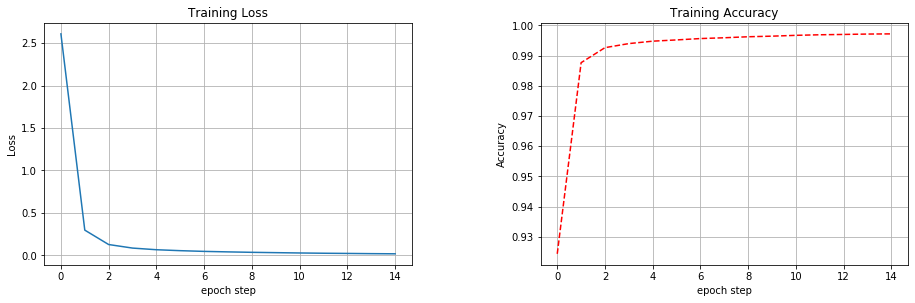

In [35]:
from matplotlib.ticker import NullFormatter  # useful for `logit` scale
import matplotlib.pyplot as plt
plt.figure()

# loss
plt.subplot(121)
plt.plot(loss_epoch)
#plt.plot(loss_epoch_test)
plt.ylabel('Loss')
plt.xlabel('epoch step')
plt.title('Training Loss')
plt.grid(True)


# Accuracy 
plt.subplot(122)
plt.plot(accuracy_epoch, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('epoch step')
plt.title('Training Accuracy')
plt.grid(True)

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.00001, right=2, hspace=0.55, wspace=0.35)

plt.show()

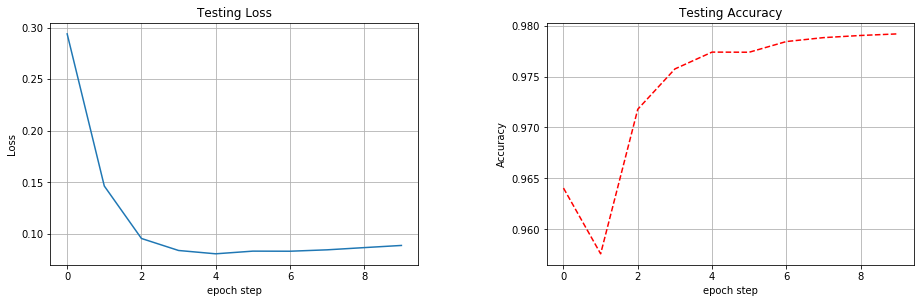

In [17]:
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

plt.figure()

# loss
plt.subplot(121)
plt.plot(loss_epoch_test)
#plt.plot(loss_epoch_test)
plt.ylabel('Loss')
plt.xlabel('epoch step')
plt.title('Testing Loss')
plt.grid(True)


# Accuracy 
plt.subplot(122)
plt.plot(accuracy_epoch_test, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('epoch step')
plt.title('Testing Accuracy')
plt.grid(True)

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.00001, right=2, hspace=0.55, wspace=0.35)

plt.show()

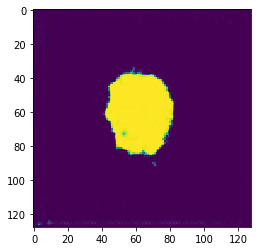

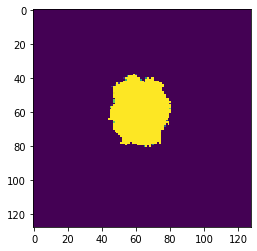

In [21]:
a = logps[0]
b = a.view((128,128))
b.shape
b = (Variable(b).data).cpu().numpy()
b.shape
plt.imshow(b)
plt.show()

aa = labels[0]
b = aa.view((128,128))
b.shape
b = (Variable(b).data).cpu().numpy()
b.shape
plt.imshow(b)
plt.show()

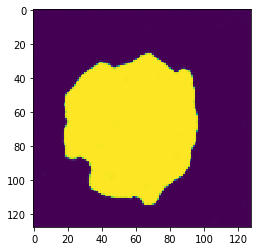

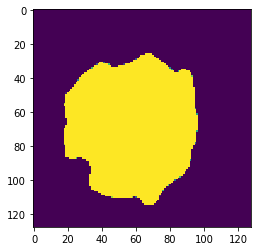

In [22]:
a = outputs[2]
b = a.view((128,128))
b.shape
b = (Variable(b).data).cpu().numpy()
b.shape
plt.imshow(b)
plt.show()

a = mask[2]
b = a.view((128,128))
b.shape
b = (Variable(b).data).cpu().numpy()
b.shape
plt.imshow(b)
plt.show()

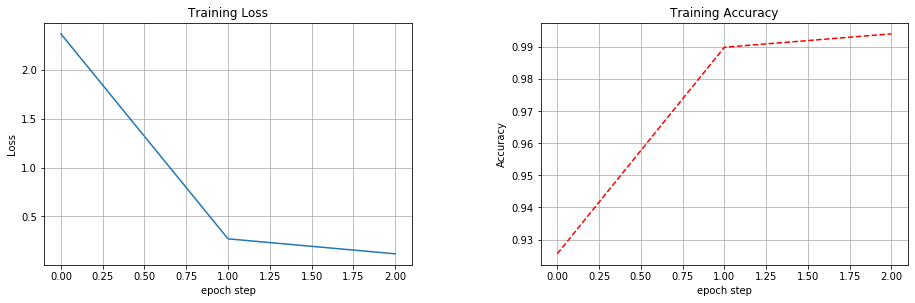

In [144]:
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

plt.figure()

# loss
plt.subplot(121)
plt.plot(loss_epoch)
plt.ylabel('Loss')
plt.xlabel('epoch step')
plt.title('Training Loss')
plt.grid(True)


# Accuracy 
plt.subplot(122)
plt.plot(accuracy_epoch, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('epoch step')
plt.title('Training Accuracy')
plt.grid(True)

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.00001, right=2, hspace=0.55, wspace=0.35)

plt.show()

In [145]:
correct = 0
total = 0
with torch.no_grad():
    for data in gen:
        inputs, labels = gen.__getitem__(0)
        inputs, labels = torch.Tensor(inputs), torch.Tensor(labels)
        inputs = inputs.view([inputs.shape[0], 1 , inputs.shape[1], inputs.shape[2]])
        labels = labels.view([labels.shape[0], 1 , labels.shape[1], labels.shape[2]])
        inputs, labels = Variable(inputs.float()), Variable(labels.float()) 
        
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
       
        

RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'other'

In [146]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in gen:
        steps += 1
        inputs, labels = gen.__getitem__(0)
        inputs, labels = torch.Tensor(inputs), torch.Tensor(labels)
        inputs = inputs.view([inputs.shape[0], 1 , inputs.shape[1], inputs.shape[2]])
        labels = labels.view([labels.shape[0], 1 , labels.shape[1], labels.shape[2]])
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        logps = torch.sigmoid(logps)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in gen:
                    inputs, labels = gen.__getitem__(0)
                    inputs, labels = torch.Tensor(inputs), torch.Tensor(labels)
                    inputs = inputs.view([inputs.shape[0], 1 , inputs.shape[1], inputs.shape[2]])
                    labels = labels.view([labels.shape[0], 1 , labels.shape[1], labels.shape[2]])
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    logps = torch.sigmoid(logps)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = 
                        top_class == labels.view(*top_class.shape)
                    accuracy +=
                    torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

SyntaxError: invalid syntax (<ipython-input-146-b233b8b07750>, line 40)

In [31]:
correct = 0 
total = 0 

test_loss = 0
accuracy = 0

train_losses, test_losses = [], []

#model.eval()

with torch.no_grad(): 
    for data in gen:
        inputs, labels = gen.__getitem__(0)
        inputs, labels = torch.Tensor(inputs), torch.Tensor(labels)
        inputs = inputs.view([inputs.shape[0], 1 , inputs.shape[1], inputs.shape[2]])
        labels = labels.view([labels.shape[0], 1 , labels.shape[1], labels.shape[2]])
        inputs, labels = Variable(inputs.float()), Variable(labels.float())
        
        logps = model.forward(inputs)
        logps = torch.sigmoid(logps)
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()
        
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = 
            top_class == labels.view(*top_class.shape)
        correct += 
        torch.mean(equals.type(torch.FloatTensor)).item()
    total +=1 

print("Accuracy: ", round(correct/total, 3))        
        
#train_losses.append(running_loss/len(trainloader))
#test_losses.append(test_loss/len(testloader))

#print(f"Epoch {epoch+1}/{epochs}.. "
 #   f"Train loss: {running_loss/print_every:.3f}.. "
  #  f"Test loss: {test_loss/len(testloader):.3f}.. "
   # f"Test accuracy: {accuracy/len(testloader):.3f}")
#running_loss = 0
#model.train()
        
        

SyntaxError: invalid syntax (<ipython-input-31-b8a3d3accbd7>, line 26)

In [12]:
X, y = data 
        output = net()
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[i]:
                correct +=1 
            total +=1
            
print("Accuracy: ", round(correct/total, 3))

#dice = 0.974
#Jaccard = 0.949

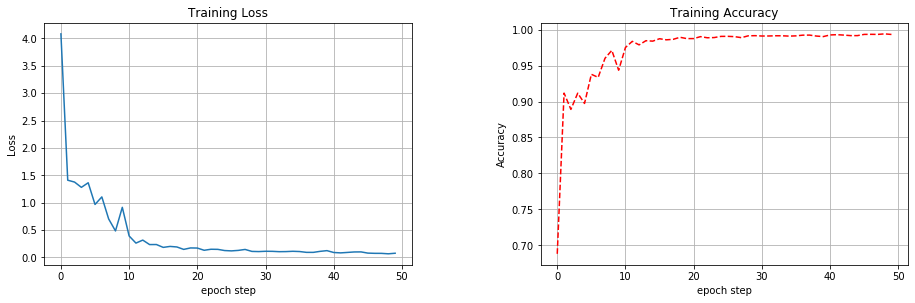

In [13]:
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

plt.figure()

# loss
plt.subplot(121)
plt.plot(loss_epoch)
plt.ylabel('Loss')
plt.xlabel('epoch step')
plt.title('Training Loss')
plt.grid(True)


# Accuracy 
plt.subplot(122)
plt.plot(accuracy_epoch, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('epoch step')
plt.title('Training Accuracy')
plt.grid(True)

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.00001, right=2, hspace=0.55, wspace=0.35)

plt.show()


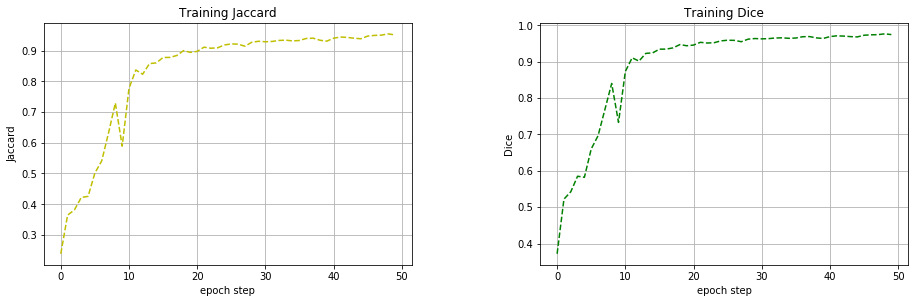

In [14]:
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

plt.figure()

# loss
plt.subplot(121)
plt.plot(jaccard_epoch, 'y--')
plt.ylabel('Jaccard')
plt.xlabel('epoch step')
plt.title('Training Jaccard')
plt.grid(True)


# Accuracy 
plt.subplot(122)
plt.plot(dice_epoch, 'g--')
plt.ylabel('Dice')
plt.xlabel('epoch step')
plt.title('Training Dice')
plt.grid(True)

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.00001, right=2, hspace=0.55, wspace=0.35)

plt.show()


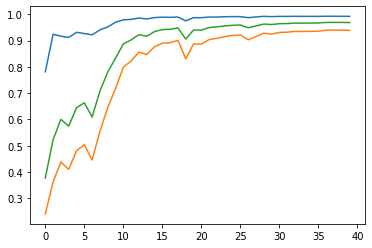

In [36]:
plt.plot(accuracy_epoch)
plt.plot(jaccard_epoch)
plt.plot(dice_epoch)


plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
#plt.subplots_adjust(top=0.92, bottom=0.08, left=0.00001, right=2, hspace=0.55, wspace=0.35)

plt.show()
            

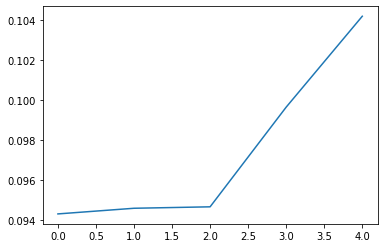

In [30]:
plt.plot(loss_values) 

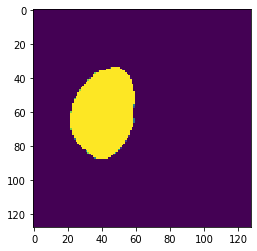

In [31]:
aa = mask[3]
bb = aa.view((128,128))
bb.shape
bb = (Variable(bb).data).cpu().numpy()
import matplotlib.pyplot as plt
plt.imshow(bb)
plt.show()

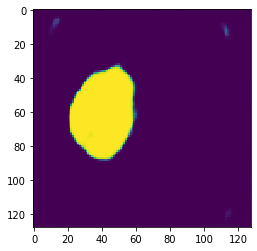

In [32]:
a = outputs[3]
b = a.view((128,128))
b.shape
b = (Variable(b).data).cpu().numpy()
b.shape
plt.imshow(b)
plt.show()

In [534]:
iou = iou_coef(outputs, mask, smooth=1)
dice = dice_coef(outputs, mask, smooth=1)
iou, dice 

(0.996022, 0.99800617)

In [486]:
#lbl = img.reshape(-1)
#target = gro.reshape(-1)
#lbl.shape, target.shape
#from sklearn.metrics import jaccard_similarity_score as jsc
#a = jsc(target,lbl)
#target 

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [507]:
#import pandas as pd 
#a = pd.cut(lbl, bins=2, labels=np.arange(2), right=False)
#b = pd.cut(target, bins=2, labels=np.arange(2), right=False)

In [509]:
#from sklearn.metrics import confusion_matrix
#y_actu = a #[2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2]
#y_pred = b #[0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2]
#Conf = confusion_matrix(a, a)#pred)
#Conf

array([[99216,     0],
       [    0, 31856]], dtype=int64)

In [518]:

#pip install utils

Note: you may need to restart the kernel to use updated packages.


In [520]:
import torch

from numpy import nanmean


EPS = 1e-10

def jaccard_index(hist):
    """Computes the Jaccard index, a.k.a the Intersection over Union (IoU).
    Args:
        hist: confusion matrix.
    Returns:
        avg_jacc: the average per-class jaccard index.
    """
    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    jaccard = A_inter_B / (A + B - A_inter_B + EPS)
    avg_jacc = nanmean(jaccard)
    return avg_jacc


In [521]:
conf = torch.tensor(Conf, dtype=torch.long, device=device)
Jacc = jaccard_index(conf)
Jacc

1.0

In [522]:
def dice_coefficient(hist):
    """Computes the Sørensen–Dice coefficient, a.k.a the F1 score.
    Args:
        hist: confusion matrix.
    Returns:
        avg_dice: the average per-class dice coefficient.
    """
    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    dice = (2 * A_inter_B) / (A + B + EPS)
    avg_dice = nanmean(dice)
    return avg_dice

In [523]:
 dice_coefficient(conf)

1.0

In [459]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from livelossplot import PlotLosses
from torch.autograd import Variable
# train on cuda if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            #for i, (inputs,labels) in enumerate (train_loader):

            for i, (inputs, labels) in enumerate(gen):
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                #inputs, labels = Variable(inputs.float()), Variable(labels.float())
                inputs, labels = gen.__getitem__(0)
                inputs, labels = torch.Tensor(inputs), torch.Tensor(labels)
                inputs = inputs.view([inputs.shape[0], 1 , inputs.shape[1], inputs.shape[2]])
                labels = labels.view([labels.shape[0], 1 , labels.shape[1], labels.shape[2]])
                inputs, labels = Variable(inputs.float()), Variable(labels.float())

                outputs = model(inputs)
                outputs = torch.sigmoid(outputs)
                loss = criterion(outputs, labels)
                labels = torch.tensor(labels, dtype=torch.long, device=device)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

               
             
                running_loss =+ loss.item() * t_image.size(0)
                #loss_values.append(running_loss)

            
            #Accuracy
                acc_output = (outputs>0.5).float()
                correct = (acc_output == mask).float().sum()
                x = outputs.shape[0]*128*128
                accuracy = correct/x
                #avg_accuracy.append(accuracy)
                
                #_, preds = torch.max(outputs, 1)
                #running_loss += loss.detach() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)

                #epoch_loss = running_loss / len(gen) #len(dataloaders[phase].dataset)
                #epoch_acc = running_corrects.float() / len(gen) #len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = running_loss
            logs[prefix + 'accuracy'] = accuracy
        
        liveloss.update(logs)
        liveloss.draw()



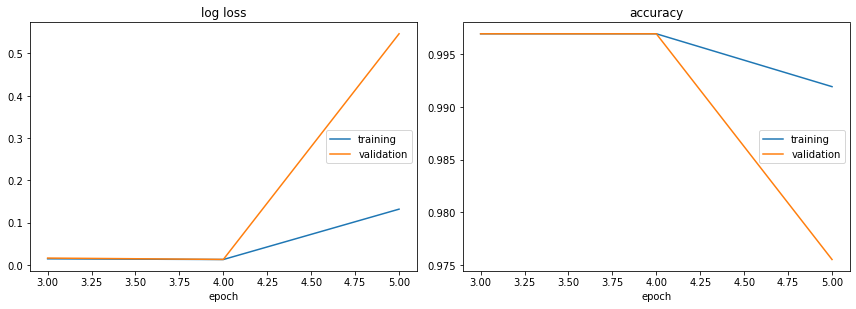

log loss:
training   (min:    0.013, max:    0.132, cur:    0.132)
validation (min:    0.013, max:    0.547, cur:    0.547)

accuracy:
training   (min:    0.992, max:    0.997, cur:    0.992)
validation (min:    0.976, max:    0.997, cur:    0.976)


In [460]:
model = SimpleNetLBC()
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
train_model(model, criterion, optimizer, num_epochs=5)

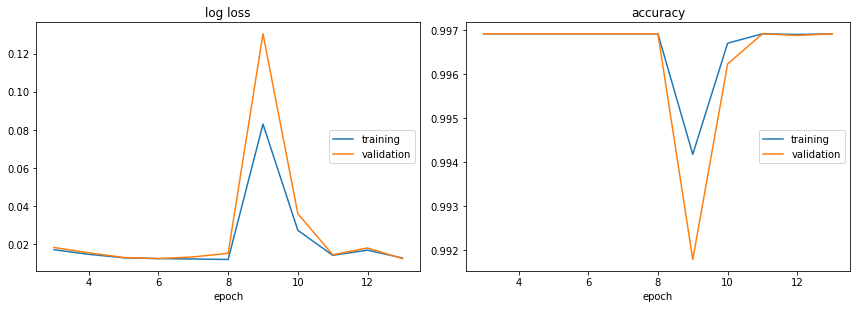

log loss:
training   (min:    0.012, max:    0.181, cur:    0.013)
validation (min:    0.012, max:    0.600, cur:    0.012)

accuracy:
training   (min:    0.990, max:    0.997, cur:    0.997)
validation (min:    0.979, max:    0.997, cur:    0.997)


KeyboardInterrupt: 

In [461]:
model = SimpleNetLBC()
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
train_model(model, criterion, optimizer, num_epochs=50)

In [251]:
from torch.utils.data import Dataset #, DataLoader
from torchvision import transforms, utils
import glob 

folder_data = glob.glob("Data256\\*.jpg")
folder_mask = glob.glob("GroundTruth_Pre\\*.png")

#folder_data.sort()

#len_data = len(folder_data)
#print(len_data)
#train_size = 0.6
#train_image_paths = folder_data[:int(len_data*train_size)]
#test_image_paths = folder_data[int(len_data*train_size):]

#train_mask_paths = folder_mask[:int(len_data*train_size)]
#test_mask_paths = folder_mask[int(len_data*train_size):]


len_data = len(folder_data)
print("count of dataset: ", len_data)
# count of dataset:  992

split_1 = int(0.8 * len(folder_data))
split_2 = int(0.9 * len(folder_data))

folder_data.sort()

train_image_paths = folder_data[:split_1]
print("count of train images is: ", len(train_image_paths)) 
#count of train images is:  793

valid_image_paths = folder_data[split_1:split_2]
print("count of validation image is: ", len(valid_image_paths))
#count of validation image is:  99

test_image_paths = folder_data[split_2:]
print("count of test images is: ", len(test_image_paths)) 
#count of test images is:  100


#print(test_image_paths)

train_mask_paths = folder_mask[:split_1]

valid_mask_paths = folder_mask[split_1:split_2]

test_mask_paths = folder_mask[split_2:]




import torch
from torch.utils.data.dataset import Dataset  # For custom data-sets
import torchvision.transforms as transforms
from PIL import Image
import numpy 
import torchvision.transforms.functional
   
        
class CustomDataset(Dataset):
    def __init__(self, image_paths, target_paths):   # initial logic happens like transform

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms = transforms.ToTensor()
        self.mapping = {
            0: 0,
            255: 1              
        }
        
    def mask_to_class(self, mask):
        for k in self.mapping:
            mask[mask==k] = self.mapping[k]
        return mask
    
    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        t_image = image.convert('L')
        t_image = self.transforms(t_image)
        #mask = torch.from_numpy(np.array(mask))    #this is for BMCC dataset
        mask = torch.from_numpy(numpy.array(mask, dtype=numpy.uint8)) # this is for my dataset(lv)
        mask = self.mask_to_class(mask)
        mask = mask.long()
        
        ## Normalizaing 
        #t_image = t_image/255.0
        #mask = mask/255.0
       
        return t_image, mask #self.image_paths[index], self.target_paths[index] 
    
    def __len__(self):  # return count of sample we have

        return len(self.image_paths)
train_dataset = CustomDataset(train_image_paths, train_mask_paths)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

valid_dataset = CustomDataset(valid_image_paths, valid_mask_paths)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True)

test_dataset = CustomDataset(test_image_paths, test_mask_paths)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
  
DataLoader = {
        'train': train_loader,
        'valid': valid_loader,
        'test': test_loader      
        }

#train_dataset = CustomDataset(train_image_paths, train_mask_paths)
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)

#test_dataset = CustomDataset(test_image_paths, test_mask_paths)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=1)

#dataLoader = {
 #       'train': train_loader,
  #      'valid': test_loader,
   #     #'test': test_loader      
    #    }



count of dataset:  2594
count of train images is:  2075
count of validation image is:  259
count of test images is:  260


In [252]:
model =  SimpleNetLBC()

In [253]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model =  SimpleNetLBC()
criterion = torch.nn.BCELoss() #nn.BCEWithLogitsLoss()  #torch.nn.BCELoss()#(size_average=True)   
optimizer = torch.optim.SGD(model.parameters(), lr=0.03) #torch.optim.Adagrad(model.parameters(), lr=0.001) 
num_epochs = 100

for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0
        total_train = 0
        correct_train = 0
        loss_values = []
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            t_image, mask = data
            #mask = mask.view([mask.shape[0], 1 , mask.shape[1], mask.shape[2]])
            t_image, mask = Variable(t_image.float()), Variable(mask.float()) #Variable(t_image.to(device)), Variable(mask.to(device))
        

            # zeroes the gradient buffers of all parameters
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(t_image) # forward
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, mask) # calculate the loss
            loss.backward() # back propagation
            optimizer.step() # update gradients
            running_loss += loss.item()
            mask = torch.tensor(mask, dtype=torch.long, device=device)
            
            #running_loss += loss.item()
            #loss_values.append(running_loss)
            
            running_loss =+ loss.item() * t_image.size(0)

    
            
            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += mask.nelement() #mask.size(0)
            correct_train += predicted.eq(mask.data).sum().item()
            train_accuracy = 100 * correct_train / total_train
            #avg_accuracy += train_accuracy 
             
        #avg_accuracy = avg_accuracy / len(train_loader)
        #print("Epoch {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(epoch+1 , num_epochs, loss.item(), avg_accuracy))   
        print('Epoch {}, train Loss: {:.3f}'.format(epoch, loss.item()), "Training Accuracy: %d %%" % (train_accuracy))
#print('Finished Training Trainset')|
        #loss_values.append(running_loss / len(train_dataset))  
#plt.plot(np.array(loss_values), 'r')
        

#plt.plot(loss_values)

C:\Users\213513306\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([8, 128, 128])) that is different to the input size (torch.Size([8, 1, 128, 128])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
C:\Users\213513306\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\213513306\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([3, 128, 128])) that is different to the input size (torch.Size([3, 1, 128, 128])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, w

Epoch 0, train Loss: -35.208 Training Accuracy: 79 %
Epoch 1, train Loss: -25.054 Training Accuracy: 79 %
Epoch 2, train Loss: -38.712 Training Accuracy: 79 %
Epoch 3, train Loss: -16.614 Training Accuracy: 79 %
Epoch 4, train Loss: -49.283 Training Accuracy: 79 %
Epoch 5, train Loss: -35.206 Training Accuracy: 79 %
Epoch 6, train Loss: -25.708 Training Accuracy: 79 %
Epoch 7, train Loss: -41.082 Training Accuracy: 79 %
Epoch 8, train Loss: -47.971 Training Accuracy: 79 %
Epoch 9, train Loss: -32.501 Training Accuracy: 79 %
Epoch 10, train Loss: -46.631 Training Accuracy: 79 %
Epoch 11, train Loss: -56.833 Training Accuracy: 79 %
Epoch 12, train Loss: -42.913 Training Accuracy: 79 %
Epoch 13, train Loss: -33.566 Training Accuracy: 79 %
Epoch 14, train Loss: -55.512 Training Accuracy: 79 %
Epoch 15, train Loss: -74.162 Training Accuracy: 79 %
Epoch 16, train Loss: -57.754 Training Accuracy: 79 %
Epoch 17, train Loss: -49.987 Training Accuracy: 79 %
Epoch 18, train Loss: -43.801 Training

KeyboardInterrupt: 

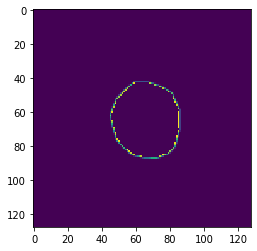

In [265]:
aa = mask[0]
bb = aa.view((128,128))
bb.shape
bb = (Variable(bb).data).cpu().numpy()
import matplotlib.pyplot as plt
plt.imshow(bb)
plt.show()

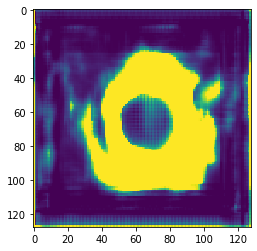

In [266]:
a = outputs[0]
b = a.view((128,128))
b.shape
b = (Variable(b).data).cpu().numpy()
b.shape
plt.imshow(b)
plt.show()

In [82]:
import torch.optim as optim 

from torch.autograd import Variable
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
criterion = torch.nn.BCELoss() 

EPOCH = 1
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for epoch in range(EPOCH):
    for data in train_loader: 
        
        X, y   = data 
        X = Variable(X.float())
        y = Variable(y.float())
        optimizer.zero_grad()
        output = model(X)
        outputs = torch.sigmoid(output)
        loss   = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        print(loss.item())
    print(loss)

0.12406090646982193
0.13974270224571228
0.13014927506446838
0.09703972190618515
0.08244311809539795
0.07066278159618378
0.060938961803913116
0.05354303866624832
0.0475773811340332
0.04202590137720108
0.036825429648160934
0.03227992728352547
0.02845665253698826
0.025236651301383972
0.022476743906736374
0.020078055560588837
0.017959490418434143
0.01607048138976097
0.014391348697245121
0.012906183488667011
0.011601168662309647
0.010462591424584389
0.009470467455685139
0.008607051335275173
0.007852478884160519
0.0071893902495503426
0.00660347705706954
0.006082755513489246
0.005618788301944733
0.005204365588724613
0.004833389539271593
0.004500646144151688
0.0042015258222818375
0.003932591527700424
0.0036904080770909786
0.003472232958301902
0.003275112481787801
0.003096897155046463
0.002935474505648017
0.002788691082969308
0.002654928946867585
0.002532671205699444
0.0024205935187637806
0.002317422768101096
0.0022222676780074835
0.0021341736428439617
0.0020525825675576925
0.001976661849766969

KeyboardInterrupt: 

In [53]:
correct = 0 
total = 0

with torch.no_grad():
    for data in train_loader:
        X, y = data 
        X = Variable(X.float())
        y = Variable(y.float())
        output = model(X)
        outputs =  torch.sigmoid(output)
        for idx, i in enumerate(outputs):
            if torch.argmax(i)==y[idx]:
                correct += 1
            total += 1
print("Accuracy: ", round(correct/total, 3))

RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'other'

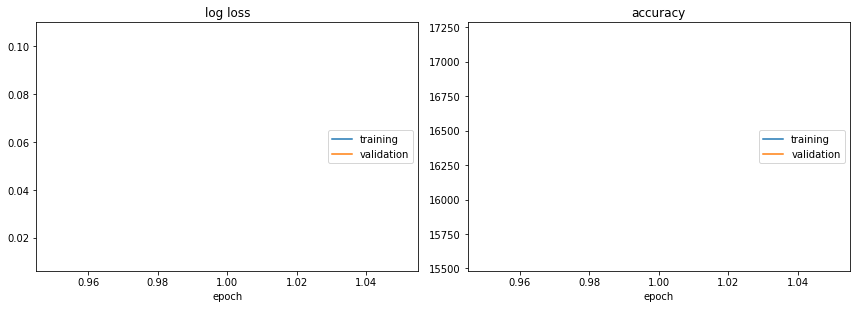

log loss:
training   (min:    0.105, max:    0.105, cur:    0.105)
validation (min:    0.011, max:    0.011, cur:    0.011)

accuracy:
training   (min: 16384.000, max: 16384.000, cur: 16384.000)
validation (min: 16384.000, max: 16384.000, cur: 16384.000)


KeyboardInterrupt: 

In [250]:
from torch.autograd import Variable
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net =  SimpleNetLBC()
criterion =    torch.nn.BCELoss()#(size_average=True) nn.BCEWithLogitsLoss()   
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 100 
for epoch in range(num_epochs):
    for i, (inputs,labels) in enumerate (train_loader):
        inputs = Variable(inputs.float())
        labels = Variable(labels.float())
        output = net(inputs)
        output = torch.sigmoid(output)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    #Accuracy
    output = (output>0.5).float()
    correct = (output == labels).float().sum()
    print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, loss.item(), correct/(output.shape[0]*output.shape[1])))

Epoch 1/100, Loss: -60.214, Accuracy: 20545.000
Epoch 2/100, Loss: -57.860, Accuracy: 13000.000
Epoch 3/100, Loss: -79.894, Accuracy: 21189.000
Epoch 4/100, Loss: -135.956, Accuracy: 22226.000
Epoch 5/100, Loss: -52.490, Accuracy: 13029.000
Epoch 6/100, Loss: -41.841, Accuracy: 9887.000
Epoch 7/100, Loss: -48.726, Accuracy: 10465.000
Epoch 8/100, Loss: -38.723, Accuracy: 10211.000
Epoch 9/100, Loss: -38.108, Accuracy: 6086.000
Epoch 10/100, Loss: -95.203, Accuracy: 11589.000
Epoch 11/100, Loss: -35.920, Accuracy: 5720.000
Epoch 12/100, Loss: -28.567, Accuracy: 2873.000
Epoch 13/100, Loss: -34.793, Accuracy: 8560.667
Epoch 14/100, Loss: -76.054, Accuracy: 15823.000
Epoch 15/100, Loss: -37.060, Accuracy: 10532.000
Epoch 16/100, Loss: -49.418, Accuracy: 17229.000
Epoch 17/100, Loss: -36.770, Accuracy: 11665.667
Epoch 18/100, Loss: -45.403, Accuracy: 11713.667
Epoch 19/100, Loss: -27.408, Accuracy: 7942.000
Epoch 20/100, Loss: -60.524, Accuracy: 16289.667
Epoch 21/100, Loss: -72.580, Accur

In [247]:
correct/16384 

tensor(0.9761)

In [246]:
128*128

16384

tensor([[0., 0., 0.],
        [0., 0., 1.],
        [1., 0., 1.]])

In [243]:

res = (data == data2).float().sum()
res/(data1.shape[0]*data1.shape[1])


tensor(0.5556)

In [200]:


# Use gpu for training if available else use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

learning_rate = 0.001
epochs = 1
num_classes = 10
batch_size = 100

# build model
model = SimpleNetLBC().to(device)
#model

# Here is the loss and optimizer definition
Sig = nn.Sigmoid()
losse = nn.BCEWithLogitsLoss() #nn.BCELoss()  
#criterion = torch.nn.NLLLoss()

optimizer = optim.SGD(model.parameters(),
                          lr=learning_rate,
                          momentum=0.9,
                          weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# The training loop
total_steps = len(train_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")
for epoch in range(epochs):
    for i, (images, masks) in enumerate(train_loader, 1):
        images = images.to(device)
        masks = masks.type(torch.LongTensor)
        masks = masks.view([masks.shape[0], masks.shape[1]* masks.shape[2]])
        masks = masks.to(device)
        masks = masks.float()
        
               
        # Forward pass
        outputs = model(images)
        outputs = outputs.view([outputs.shape[0], outputs.shape[1]*outputs.shape[2]*outputs.shape[3]])
        #softmax = F.log_softmax(outputs, dim=1)
        #loss = criterion(softmax, masks)
        outputs = torch.sigmoid(outputs)
        output = losse(outputs, masks)
        
        # Backward and optimize
        optimizer.zero_grad()
        #loss.backward()
        output.backward()
        optimizer.step()
        
        #Accuracy
        output = (output>0.5).float()
        correct = (output == masks).float().sum()
        #print( correct/output.shape[0])
        
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {output.item():4f}")



1 epochs, 260 total_steps per epoch
Epoch [1/1], Step [100/260], Loss: 0.000000
Epoch [1/1], Step [200/260], Loss: 0.000000


In [141]:
net = Model()
criterion = torch.nn.BCELoss(size_average=True)   
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 100
for epoch in range(num_epochs):
    for i, (inputs,labels) in enumerate (train_loader):
        inputs = Variable(inputs.float())
        labels = Variable(labels.float())
        output = net(inputs)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    #Accuracy
    output = (output>0.5).float()
    correct = (output == labels).float().sum()
    print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, loss.data[0], correct/output.shape[0]))

torch.Size([4, 1, 128, 128])

In [182]:


import os
from PIL import Image
from torchvision import transforms, utils
from utils import resize_and_crop, get_square, normalize, hwc_to_chw


def get_ids(dir):
    return (f[:-4] for f in os.listdir(dir))


def split_ids(ids, n=2):
    # Split each id in n, creating n tuples (id, k) for each id
    return ((id, i)  for id in ids for i in range(n))


def to_cropped_imgs(ids, dir, suffix, scale):
    """From a list of tuples, returns the correct cropped img"""
    for id1, pos in ids:
        id = id1.replace(".", "")
        im = resize_and_crop(Image.open(dir + id + suffix), scale=scale)
        yield get_square(im, pos)


def get_imgs_and_masks(ids, dir_img, dir_mask, scale):
    """Return all the couples (img, mask)"""

    imgs = to_cropped_imgs(ids, dir_img, '.jpg', scale)

    # need to transform from HWC to CHW
    imgs_switched = map(hwc_to_chw, imgs)
    imgs_normalized = map(normalize, imgs_switched)

    masks = to_cropped_imgs(ids, dir_mask, '_mask.jpg', scale)

    return zip(imgs_normalized, masks)

ModuleNotFoundError: No module named 'utils'

In [178]:
import os
import sys
import time
from optparse import OptionParser

import numpy as np
import torch
import torch.nn as nn
from torch import optim

#from unet import UNet
from utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch


def train_net(net,
              epochs=5,
              batch_size=1,
              lr=0.1,
              val_percent=0.05,
              save_cp=True,
              gpu=True,
              img_scale=0.5):

    dir_mask = 'C:/Users/213513306/Desktop/own_data_cnn_implementation_keras-master/GroundTruth_Pre/'
    dir_img = 'C:/Users/213513306/Desktop/own_data_cnn_implementation_keras-master/Data256/'

    dir_checkpoint = 'checkpoints/'

    ids = get_ids(dir_img)
    ids = split_ids(ids)

    iddataset = split_train_val(ids, val_percent)

    print('''
    Starting training:
        Epochs: {}
        Batch size: {}
        Learning rate: {}
        Training size: {}
        Validation size: {}
        Checkpoints: {}
        CUDA: {}
    '''.format(epochs, batch_size, lr, len(iddataset['train']),
               len(iddataset['val']), str(save_cp), str(gpu)))

    N_train = len(iddataset['train'])

    optimizer = optim.SGD(net.parameters(),
                          lr=lr,
                          momentum=0.9,
                          weight_decay=0.0005)

    criterion = nn.BCELoss()

    # train = get_imgs_and_masks(iddataset['train'], dir_img, dir_mask, img_scale)
    # print(train[0])

    for epoch in range(epochs):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net.train()

        # reset the generators
        train = get_imgs_and_masks(iddataset['train'], dir_img, dir_mask, img_scale)
        # val = get_imgs_and_masks(iddataset['val'], dir_img, dir_mask, img_scale)

        epoch_loss = 0

        for i, b in enumerate(batch(train, batch_size)):
            imgs = np.array([i[0] for i in b])
            # imgs = np.array([i[0] for i in b]).astype(np.float32)
            true_masks = np.array([i[1] for i in b])

            imgs = torch.from_numpy(imgs)
            true_masks = torch.from_numpy(true_masks)

            if gpu:
                imgs = imgs.cuda()
                true_masks = true_masks.cuda()

            masks_pred = net(imgs)
            masks_probs_flat = masks_pred.view(-1)

            true_masks_flat = true_masks.view(-1)

            loss = criterion(masks_probs_flat, true_masks_flat)
            epoch_loss += loss.item()

            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch finished ! Loss: {}'.format(epoch_loss / i))

        # if 1:
        #     val_dice = eval_net(net, val, gpu)
        #     print('Validation Dice Coeff: {}'.format(val_dice))

        if save_cp:
            torch.save(net.state_dict(),
                       dir_checkpoint + 'CP{}.pth'.format(epoch + 1))
            print('Checkpoint {} saved !'.format(epoch + 1))

In [179]:
train_net(model,
              epochs=5,
              batch_size=1,
              lr=0.1,
              val_percent=0.05,
              save_cp=True,
              gpu=True,
              img_scale=0.5)

NameError: name 'split_train_val' is not defined

In [137]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = model #"model-1570499409" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

FileNotFoundError: [Errno 2] No such file or directory: 'model.log'

count of dataset:  2594
count of train images is:  2075
count of validation image is:  259
count of test images is:  260


2 epochs, 260 total_steps per epoch
Epoch [1/2], Step [100/260], Loss: -0.961029
Epoch [1/2], Step [200/260], Loss: -1.584144
Epoch [2/2], Step [100/260], Loss: -1.007573
Epoch [2/2], Step [200/260], Loss: -1.665776


In [118]:
#import win32file
#win32file._setmaxstdio(2048)
outputs = outputs.view([outputs.shape[0], 1 , 128,128])
outputs.shape, masks.shape

(torch.Size([3, 1, 128, 128]), torch.Size([3, 16384]))

In [101]:
inputs = outputs.view([outputs.shape[0], outputs.shape[1]*outputs.shape[2]*outputs.shape[3]])
target = masks.view([masks.shape[0],masks.shape[1]*masks.shape[2]])
target = target.float()
m = nn.Sigmoid()
losse = nn.BCELoss()
inp = m(inputs)
output = losse(inp, target)
output.backward()

In [102]:
output

tensor(-0.0278, grad_fn=<BinaryCrossEntropyBackward>)

(torch.Size([8, 1, 128, 128]), torch.Size([8, 128, 128]))

In [51]:
softmax[1]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<SelectBackward>)

In [52]:
loss = nn.NLLLoss()
output = loss(softmax, masks)
output.backward()

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\THNN/generic/SpatialClassNLLCriterion.c:111

In [491]:
print(outputs.shape)

torch.Size([32, 1, 128, 128])


In [493]:
X = outputs[5].view([128,128])
X.shape

torch.Size([128, 128])

In [494]:
X

tensor([[ 0.3068,  0.2855,  0.2250,  ...,  0.1715,  0.2238,  0.3326],
        [ 0.2392,  0.1883,  0.1624,  ...,  0.1496,  0.2611,  0.2143],
        [ 0.2465,  0.2494,  0.3716,  ...,  0.2715,  0.1847,  0.2995],
        ...,
        [ 0.3161,  0.1118, -0.0681,  ...,  0.3170,  0.1606,  0.0590],
        [ 0.2071,  0.0774,  0.3305,  ...,  0.4389,  0.1818,  0.2585],
        [ 0.2506,  0.0918,  0.0910,  ...,  0.0600,  0.1926,  0.1868]],
       grad_fn=<ViewBackward>)

In [524]:
for i, (images, masks) in enumerate(train_loader, 1):
        images = images.to(device)
        masks = masks.type(torch.LongTensor)
        masks = masks.view([masks.shape[0], 1, masks.shape[1], masks.shape[2]])
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        softmax = F.log_softmax(outputs, dim=1)
        loss = criterion(softmax, masks)
        break 

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 268435456 bytes. Buy new RAM!


In [522]:

masks.shape

torch.Size([32, 1, 128, 128])

In [509]:
softmax.shape, masks.shape

(torch.Size([32, 1, 128, 128]), torch.Size([32, 1, 128, 128]))

RuntimeError: shape '[32, 1, 1, 128]' is invalid for input of size 524288

In [67]:
for data in train_dataset:
    print(data)
    break

(tensor([[[0.9922, 0.9373, 0.9843,  ..., 0.9765, 0.9647, 1.0000],
         [0.9137, 0.7098, 0.6980,  ..., 0.7765, 0.7725, 0.9608],
         [0.9765, 0.6980, 0.6275,  ..., 0.7137, 0.7294, 0.9804],
         ...,
         [0.9765, 0.7608, 0.7333,  ..., 0.8314, 0.8314, 0.9804],
         [0.9451, 0.7569, 0.7529,  ..., 0.8588, 0.8353, 0.9725],
         [0.9882, 0.9490, 0.9922,  ..., 0.9765, 0.9490, 1.0000]]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'Data1\\ISIC_0000000.jpg', 'GroundTruth\\ISIC_0000000_segmentation.png')


In [468]:
print(data[0][0].shape)

torch.Size([767, 1022])


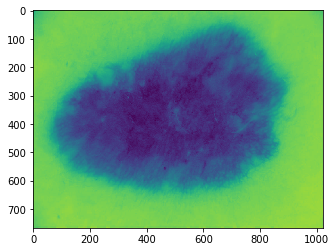

In [69]:
plt.imshow(data[0][0])
plt.show()

In [72]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
#from lbcnn import SimpleNetLBC, SimpleNetCNN
import time
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# build model
model = SimpleNetLBC().to(device)
num_epochs = 1
num_classes = 10
batch_size = 100
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
total_step = len(train_loader)
strat = time.time()

In [23]:
# Use gpu for training if available else use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Here is the loss and optimizer definition
learning_rate = 0.001
epochs = 10
num_classes = 10
batch_size = 100
learning_rate = 0.001
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# The training loop
total_steps = len(train_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")
for epoch in range(epochs):
    for i, (images, masks) in enumerate(train_loader, 1):
        images = images.to(device)
        masks = masks.type(torch.LongTensor)
        masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3])
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        softmax = F.log_softmax(outputs, dim=1)
        loss = criterion(softmax, masks)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}")

10 epochs, 2075 total_steps per epoch


BrokenPipeError: [Errno 32] Broken pipe

(tensor([[[0.9922, 0.9373, 0.9843,  ..., 0.9765, 0.9647, 1.0000],
         [0.9137, 0.7098, 0.6980,  ..., 0.7765, 0.7725, 0.9608],
         [0.9765, 0.6980, 0.6275,  ..., 0.7137, 0.7294, 0.9804],
         ...,
         [0.9765, 0.7608, 0.7333,  ..., 0.8314, 0.8314, 0.9804],
         [0.9451, 0.7569, 0.7529,  ..., 0.8588, 0.8353, 0.9725],
         [0.9882, 0.9490, 0.9922,  ..., 0.9765, 0.9490, 1.0000]]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'Data1\\ISIC_0000000.jpg', 'GroundTruth\\ISIC_0000000_segmentation.png')


In [33]:
folder_data = glob.glob("Data1\\*.jpg")
folder_mask = glob.glob("GroundTruth\\*.png")

len_data = len(folder_data)
print(len_data)
train_size = 0.6
train_images = folder_data[:int(len_data*train_size)]
test_images = folder_data[int(len_data*train_size):]

train_masks = folder_mask[:int(len_data*train_size)]
test_masks = folder_mask[int(len_data*train_size):]
len(train_images), len(train_masks), len(test_images), len(test_masks)

2594


(1556, 1556, 1038, 1038)

In [35]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
number_of_classes =1
class FormsDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):   # initial logic 
        #happens like transform

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms = transforms.ToTensor()

    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        t_image = self.transforms(image)
        return t_image, mask

    def __len__(self):  # return count of sample we have
        return len(self.image_paths)
train_dataset1 = FormsDataset(train_images, train_masks, train=True)
train_data_loader1 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f'Train dataset has {len(train_data_loader1)} batches of size {batch_size}')

Train dataset has 21 batches of size 100


In [36]:
for data in train_dataset1:
    print(data)
    break

(tensor([[[0.9843, 0.9098, 0.9529,  ..., 0.9294, 0.9333, 1.0000],
         [0.9020, 0.6863, 0.6471,  ..., 0.6941, 0.7216, 0.9529],
         [0.9608, 0.6706, 0.5765,  ..., 0.6118, 0.6627, 0.9529],
         ...,
         [0.9333, 0.6980, 0.6627,  ..., 0.7294, 0.7608, 0.9490],
         [0.9098, 0.7176, 0.7137,  ..., 0.7804, 0.7882, 0.9569],
         [0.9882, 0.9373, 0.9765,  ..., 0.9333, 0.9176, 1.0000]],

        [[1.0000, 0.9451, 1.0000,  ..., 1.0000, 0.9804, 1.0000],
         [0.9176, 0.7176, 0.7098,  ..., 0.7961, 0.7843, 0.9647],
         [0.9843, 0.7020, 0.6392,  ..., 0.7412, 0.7451, 0.9922],
         ...,
         [1.0000, 0.7686, 0.7373,  ..., 0.8627, 0.8510, 0.9961],
         [0.9569, 0.7647, 0.7608,  ..., 0.8824, 0.8510, 0.9765],
         [1.0000, 0.9647, 1.0000,  ..., 1.0000, 0.9608, 1.0000]],

        [[1.0000, 0.9725, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9529, 0.7608, 0.7725,  ..., 0.9020, 0.8471, 0.9843],
         [1.0000, 0.7765, 0.7294,  ..., 0.8706, 0.8275, 1

In [335]:
# Use gpu for training if available else use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Here is the loss and optimizer definition
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# The training loop
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")
for epoch in range(epochs):
    for i, (images, masks) in enumerate(train_data_loader, 1):
        images = images.to(device)
        masks = masks.type(torch.LongTensor)
        masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3])
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        softmax = F.log_softmax(outputs, dim=1)
        loss = criterion(softmax, masks)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}")
        

100 epochs, 16 total_steps per epoch


OSError: [Errno 24] Too many open files: 'Data1\\ISIC_0010014.jpg'

In [267]:
PATH = os.getcwd()
# Define data path
data_path  = PATH + '/Data1'
image_paths = os.listdir(data_path)

mask_path = PATH + '/GroundTruth'
target_paths = os.listdir(mask_path)

len(image_paths), len(target_paths)


(2594, 2594)

2594


389

In [ ]:
# Use gpu for training if available else use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Here is the loss and optimizer definition
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# The training loop
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")
for epoch in range(epochs):
    for i, (images, masks) in enumerate(train_data_loader, 1):
        images = images.to(device)
        masks = masks.type(torch.LongTensor)
        masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3])
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        softmax = F.log_softmax(outputs, dim=1)
        loss = criterion(softmax, masks)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}")

In [302]:
# build model
model = SimpleNetLBC().to(device)
num_epochs = 1
num_classes = 10
batch_size = 100
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
strat = time.time()

for eopch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            end = time.time()
            print('epoch %d, iter %d: loss %.3f, time: %.3f' % (eopch+1, i+1, loss.item(), (end-strat)))
            strat = time.time()


In [292]:


for eopch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            end = time.time()
            print('epoch %d, iter %d: loss %.3f, time: %.3f' % (eopch+1, i+1, loss.item(), (end-strat)))
            strat = time.time()

# eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
model.eval() 
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

torch.save(model.state_dict(), 'model.ckpt')

OSError: [Errno 24] Too many open files: 'C:\\Users\\213513306\\AppData\\Local\\Continuum\\anaconda3\\lib\\multiprocessing\\queues.py'

In [276]:
# get all the image and mask path and number of images
folder_data = glob.glob("Data1\\*.jpg")
folder_mask = glob.glob("GroundTruth\\*.png")

# split these path using a certain percentage
len_data = len(folder_data)
print(len_data)
train_size = 0.6

train_image_paths = folder_data[:int(len_data*train_size)]
test_image_paths = folder_data[int(len_data*train_size):]

train_mask_paths = folder_mask[:int(len_data*train_size)]
test_mask_paths = folder_mask[int(len_data*train_size):]


class CustomDataset():
    def __init__(self, image_paths, target_paths, train=True):   # initial logic 
        #happens like transform

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms = transforms.ToTensor()

    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        t_image = self.transforms(image)
        return t_image, mask

def __len__(self):  # return count of sample we have

    return len(self.image_paths)

train_dataset = CustomDataset(train_image_paths, train_mask_paths, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)

test_dataset = CustomDataset(test_image_paths, test_mask_paths, train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=1)

2594


TypeError: object of type 'CustomDataset' has no len()

In [261]:
from PIL import Image
import glob

In [263]:

image_list = []
for filename in glob.glob('Data1/*.jpg'): #assuming gif
    im= Image.open(filename)
    image_list.append(im)




OSError: [Errno 24] Too many open files: 'Data1\\ISIC_0000496.jpg'

In [246]:
mask_list = []
for filenames in glob.glob('GroundTruth/*.png'): #assuming gif
    im=Image.open(filenames)
    mask_list.append(im)
    

OSError: [Errno 24] Too many open files: 'GroundTruth\\ISIC_0000000_segmentation.png'

In [265]:
class CustomDataset():
    def init(self, image_paths, target_paths, transform_images, transform_masks):
        self.image_paths = image_paths
        self.target_paths = target_paths

        self.transform_images = transform_images
        self.transform_masks = transform_masks


        self.transformm = transforms.Compose([transforms.Lambda(lambda x: tf.rotate(x, 10)),
                                              transforms.Lambda(lambda x: tf.affine(x, angle=0,
                                          translate=(0, 0),
                                          scale=0.2,
                                          shear=0.2))
                                            ])

        self.transform = transforms.ToTensor()

        self.mapping = {
            0: 0,
            255: 1              
        }

    def mask_to_class(self, mask):
        for k in self.mapping:
            mask[mask==k] = self.mapping[k]
        return mask

    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])

        if any([img in self.image_paths[index] for img in self.transform_images]):
            print('applying special transformation')
            image = self.transformm(image) #augmentation

        if any([msk in self.target_paths[index] for msk in self.transform_masks]):
            print('applying special transformation')
            image = self.transformm(mask) #augmentation

        t_image = image.convert('L')
        t_image = self.transform(t_image) # transform to tensor for image
        mask = self.transform(mask) # transform to tensor for mask


        mask = torch.from_numpy(numpy.array(mask, dtype=numpy.uint8)) 
        mask = self.mask_to_class(mask)
        mask = mask.long()

        return t_image, mask, self.image_paths[index], self.target_paths[index] 

    def __len__(self):  # return count of sample we have

        return len(self.image_paths)

In [266]:
folder = CustomDataset(image_paths, target_paths)

TypeError: CustomDataset() takes no arguments

In [218]:
from PIL import Image
from torchvision import transforms
from torchvision.transforms import functional as tvF

class MyDataset():
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths

    def transform(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(128, 128))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(512, 512))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.image_paths)

In [219]:

y = MyDataset(image_list, mask_list)
y

In [221]:
model = SimpleNetLBC(y[0])

AttributeError: 'JpegImageFile' object has no attribute 'read'

In [176]:
from torch import nn, optim, from_numpy
import numpy as np
x_data = from_numpy(img_org1)
y_data = from_numpy(img_ground1)
print(f'X\'s shape: {x_data.shape} | Y\'s shape: {y_data.shape}')

X's shape: torch.Size([60, 1, 128, 128]) | Y's shape: torch.Size([60, 1, 128, 128])


In [155]:
def load_dataset():
    data_path = 'Data1/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader1 = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True
    )
    return train_loader1

train_loader1 = load_dataset()


    

RuntimeError: Found 0 files in subfolders of: Data1
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif,.tiff,.webp

In [ ]:
model = SimpleNetLBC()


# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = nn.BCELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
for epoch in range(100):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_data)

    # Compute and print loss
    loss = criterion(y_pred, y_data)
    print(f'Epoch: {epoch + 1}/100 | Loss: {loss.item():.4f}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [147]:
model = SimpleNetLBC()


# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = nn.BCELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
for epoch in range(100):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_data)

    # Compute and print loss
    loss = criterion(y_pred, y_data)
    print(f'Epoch: {epoch + 1}/100 | Loss: {loss.item():.4f}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

RuntimeError: Given groups=1, weight of size 128 256 3 3, expected input[60, 384, 8, 8] to have 256 channels, but got 384 channels instead

In [75]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
#from lbcnn import SimpleNetLBC, SimpleNetCNN
import time
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# build model
model = SimpleNetLBC()

train_loader = torch.utils.data.DataLoader(dataset=x, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=y, batch_size=batch_size, shuffle=False)


num_epochs = 1
num_classes = 10
batch_size = 100
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
strat = time.time()

outputs = model(x)




TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [45]:
for eopch in range(num_epochs):
    for images in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            end = time.time()
            print('epoch %d, iter %d: loss %.3f, time: %.3f' % (eopch+1, i+1, loss.item(), (end-strat)))
            strat = time.time()

AttributeError: 'numpy.ndarray' object has no attribute 'to'